In [44]:
# import lithosphere_prior
#import sys
#sys.path.append('../lithosphere_prior')
#from lithosphere_prior import LithospherePrior

import matplotlib.pyplot as plt
import datetime as dt

from viresclient import SwarmRequest

import GMT_tools as gt

# Import rest
from sdss_stochastic import SDSS_stochastic
import utility as sds_util
import plot as sds_plt

import numpy as np

In [45]:
request = SwarmRequest()

In [46]:
request.set_collection("SW_OPER_MAGA_LR_1B")

#request.set_products(measurements=["F","B_NEC"],
#                     models=["MCO_SHA_2C", "MMA_SHA_2C-Primary", "MMA_SHA_2C-Secondary"],
#                     auxiliaries=["QDLat", "QDLon", "MLT", "OrbitNumber", "SunZenithAngle"],
#                     residuals=False,
#                     sampling_step="PT10S")

request.set_products(measurements=["B_NEC"],
                     models = ["CHAOS-MMA-Primary"],
                     auxiliaries=["SunZenithAngle", "Kp"],
                     residuals=False,
                     sampling_step="PT120S")

request.set_range_filter(parameter="Latitude", minimum= -90, maximum=90)

request.set_range_filter("Longitude", -180, 180)

data = request.get_between(start_time=dt.datetime(2016,1,1),
                           end_time=dt.datetime(2016,1,2))

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.098MB)


In [47]:
ds = data.as_xarray()
print(ds)

<xarray.Dataset>
Dimensions:                  (NEC: 3, Timestamp: 720)
Coordinates:
  * Timestamp                (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:58:00
  * NEC                      (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft               (Timestamp) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    B_NEC                    (Timestamp, NEC) float64 -1.581e+03 ... 2.82e+04
    B_NEC_CHAOS-MMA-Primary  (Timestamp, NEC) float64 -19.92 -1.451 ... 26.49
    Radius                   (Timestamp) float64 6.834e+06 ... 6.824e+06
    Longitude                (Timestamp) float64 92.79 99.1 ... -95.23 -95.33
    SunZenithAngle           (Timestamp) float64 67.46 65.78 ... 90.03 93.49
    Latitude                 (Timestamp) float64 -72.5 -80.01 ... 16.35 24.05
    Kp                       (Timestamp) float64 5.7 6.0 6.0 6.0 ... 1.7 1.7 1.7
Attributes:
    Sources:         ['SW_OPER_AUX_KP__2__19980101T013000_20200221T103000_000...
    MagneticModels:  ["CHAOS-MMA-Primary =

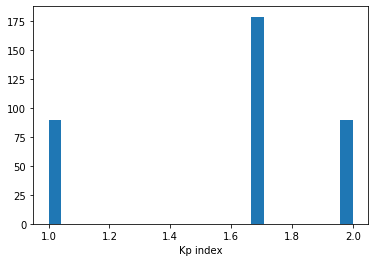

In [48]:
SZA_angle = 0
Kp_max = 3
idx_sort= np.logical_and(np.abs(ds.SunZenithAngle)>SZA_angle,ds.Kp<Kp_max)

plt.figure()
plt.hist(ds.Kp[idx_sort],bins=24)
plt.xlabel("Kp index")
plt.show()

In [49]:
B_s_r = -ds.B_NEC[:,2][idx_sort] + ds["B_NEC_CHAOS-MMA-Primary"][:,2][idx_sort]
B_s_t = -ds.B_NEC[:,0][idx_sort] + ds["B_NEC_CHAOS-MMA-Primary"][:,0][idx_sort]
B_s_p = ds.B_NEC[:,1][idx_sort] - ds["B_NEC_CHAOS-MMA-Primary"][:,1][idx_sort]

In [50]:
# CORE GRID
core = SDSS_stochastic(sim_type = "core", N_grid = 700)
#core.grid(core.a, grid_in, calc_sph_d = True)
core.grid(core.r_cmb, "gauss_leg", calc_sph_d = True)
core.data()
core.condtab()
core.semivar(model_lags = 'all', model = "exponential", max_dist = 2500, lag_length = 50, zero_nugget = True)

del core.sph_d

print(core)



____semi-variogram setup___

Number of data used: 77026
Max data distance: 2499.954 km
Lag length chosen: 50.0 km
Number of lags: 49
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation


______current attributes______

a:                     6371.2
r_cmb:                 3480.0
r_sat:                 6721.2
rad:                   0.017453292519943295
mu0:                   1.2566370614359172
N_grid:                722
N_SH:                  60
sim_type:              core
r_grid:                3480.0
grid:                  gauss_leg
gauss_leg_n_from_N:    19
weights:               (722,), Max/Min: 0.16 / 0.02
lon:                   (722,), Max/Min: 350.53 / 0.00
lat:                   (722,), Max/Min: 82.93 / -82.93
data:                  (722,), Max/Min: 4196560.38 / -2711918.98
r_grid_repeat:         (722,), Max/Min: 3480.00 / 3480.00
target_var:            345157214387.55695
target_mean:           0.0
CQF_dist:              (501, 101, 100)
CQF_m

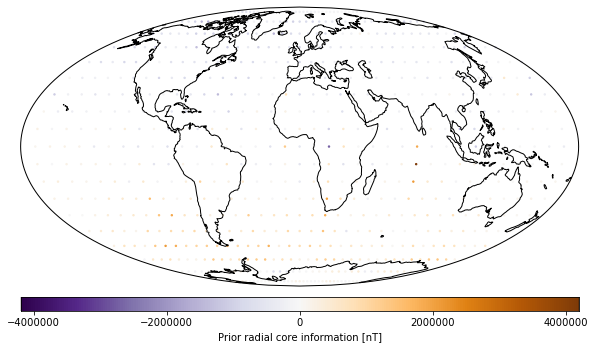

In [51]:
#%% PLOT SYNTHETIC DATA
sds_util.plot_cartopy_global_new(core.lat, core.lon, data=core.data, plot_quality = "high", cmap = 'PuOr_r', title="Prior radial core information", scale_uneven = False)

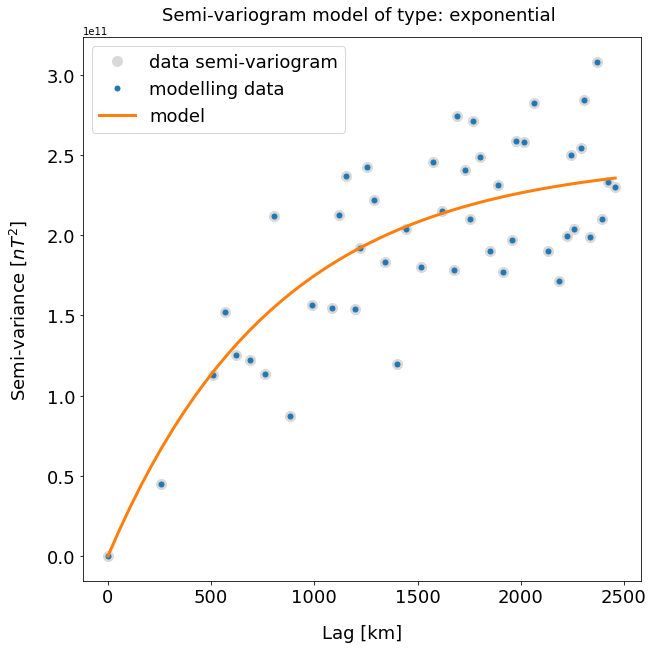

In [52]:
plt.figure(figsize=(10,10)) 
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',linewidth = 3,label='model')
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [53]:
N = core.N_grid
radius = core.r_cmb

n_approx_from_N = int(np.ceil(np.sqrt(N/2)))
leggaus = np.polynomial.legendre.leggauss(n_approx_from_N)
lat = 90-np.flipud(np.arccos(leggaus[0]).reshape(-1,1))*180/np.pi
lon = np.arange(0,2*np.pi,np.pi/n_approx_from_N)*180/np.pi
weights, none = np.meshgrid(leggaus[1],lon,indexing='ij')
lat, lon = np.meshgrid(lat,lon,indexing='ij')
lon = lon.ravel()
lat = lat.ravel()
N = 2*n_approx_from_N**2
#if calc_sph_d is not False:     
#    lon_mesh, lat_mesh = np.meshgrid(lon,lat,indexing='ij')
#    sph_d = sds_util.haversine(radius, lon_mesh, lat_mesh, lon_mesh.T, lat_mesh.T)

grid = {"N":N, "lat":lat, "lon":lon, "radius":radius, "weights":np.ravel(weights), "n":n_approx_from_N}

In [78]:
#G_d = np.pi/grid["n"]*np.multiply(grid["weights"].reshape(-1,1),sds_util.Gr_vec(ds.Radius[idx_sort]*10**(-3), grid["radius"], ds.Latitude[idx_sort], grid["lat"], ds.Longitude[idx_sort], grid["lon"]))
G_d = np.pi/grid["n"]*np.multiply(grid["weights"].reshape(1,-1),sds_util.Gr_vec(grid["radius"], ds.Radius[idx_sort]*10**(-3), grid["lat"], ds.Latitude[idx_sort], grid["lon"], ds.Longitude[idx_sort]))

print(np.shape(G_d))
print(np.shape(np.ravel(B_s_r).reshape(-1,1)))

(359, 722)
(359, 1)


In [79]:
np.shape(G_d)[1]

722

In [80]:
errorvar = 0.5*10**(1)

def covmod_lsq_equiv(prior,obs,step,semivar,target_var,G_d,title="",errorvar = 10e2):
    a_0 = np.empty([0,])
    b_0 = obs
    d_0 = b_0

    G = G_d.copy()
    C_M = target_var - semivar
    C_D = np.zeros((len(a_0)+len(b_0),len(a_0)+len(b_0)))
    C_D[np.arange(len(a_0)+1,len(a_0)+len(b_0)),np.arange(len(a_0)+1,len(a_0)+len(b_0))] = errorvar
    S = C_D + G*C_M*G.T
    T = np.linalg.inv(S)
    m_equiv_lsq = C_M*G.T*T*d_0
    lsq_equiv_pred = G_d*m_equiv_lsq
    lsq_equiv_res = obs - lsq_equiv_pred
    return m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res

m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res = covmod_lsq_equiv(core,np.ravel(B_s_r).reshape(-1,1),10,core.sv_lut,core.target_var,G_d.T,title="Gauss-Legendre equivalent LSQ solution",errorvar = errorvar)

# RMSE
rmse_leg = np.sqrt(np.mean(np.power(lsq_equiv_res,2)))
print("")
print("Gauss-Legendre RMSE:\t %0.3f" %rmse_leg)
plt.figure()
y,binEdges=np.histogram(lsq_equiv_res,bins=200)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'C0',label="Gauss-Legendre")
plt.xlabel("Radial field residuals [nT]")
plt.ylabel("Count")
plt.legend()
plt.show()

sds_util.plot_cartopy_global_new(core.lat, core.lon, data=np.ravel(m_equiv_lsq), plot_quality = "high", cmap = 'PuOr_r', title="Gauss-Legendre equivalent LSQ solution", scale_uneven = False)

ValueError: shapes (722,359) and (722,722) not aligned: 359 (dim 1) != 722 (dim 0)

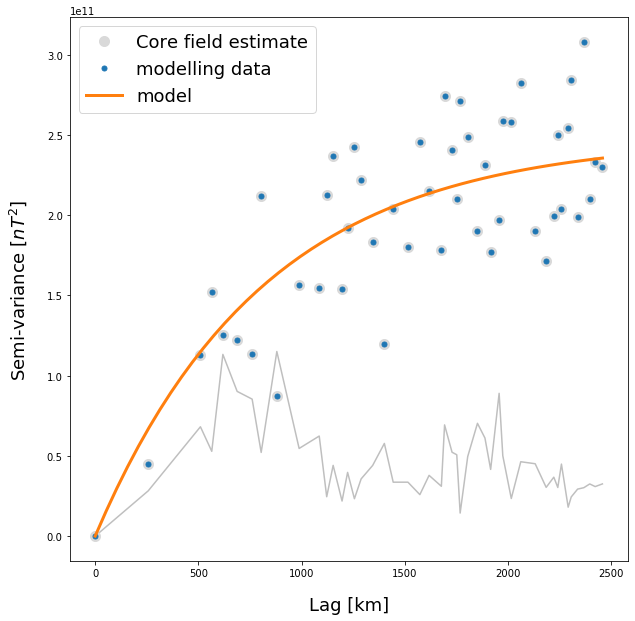

In [58]:
N_sim = 1
#% SEMI-VARIOGRAM
core.sv_zs(core.N_grid,1,np.ravel(m_equiv_lsq).reshape(-1,1),core.sort_d,core.n_lags,core.max_cloud)

plt.figure(figsize=(10,10))
plt.plot(core.lags,core.pics_zs[:,0],color = '0.75')    
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='Core field estimate')
plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',linewidth = 3,label='model')
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.legend(loc='best',fontsize=18)
plt.show()

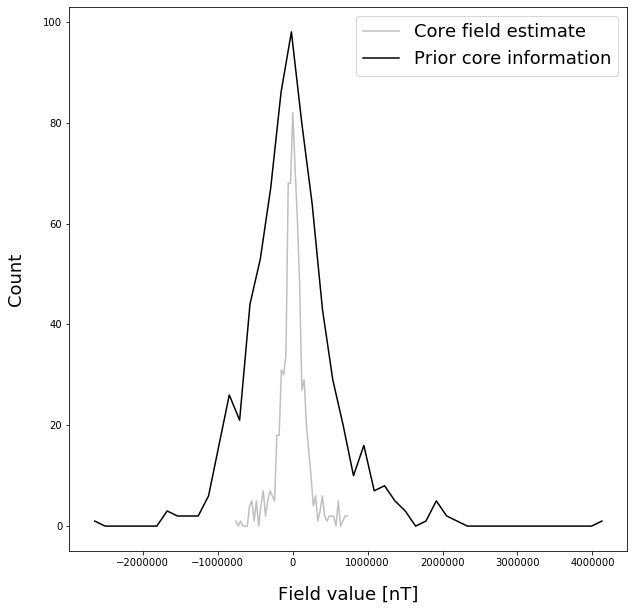

In [14]:
#% HISTOGRAM
plt.figure(figsize=(10,10))    
y,binEdges=np.histogram(np.ravel(m_equiv_lsq).reshape(-1,1)[:,0],bins=50,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',color = '0.75',label='Core field estimate')    

y,binEdges=np.histogram(core.data,bins=50,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'k-',label='Prior core information')
plt.legend(loc='best',fontsize=18)
plt.xlabel('Field value %s' % "[nT]",fontsize=18,labelpad=18)
plt.ylabel('Count',fontsize=18,labelpad=18)
plt.show()

In [91]:
G_k = G_d*(core.target_var-core.sv_lut)
GG_K = (G_k*G_d.T  + np.diag(errorvar*np.ones(np.shape(G_d)[0],))).T

sort_support = np.flipud(np.argsort(G_k,axis=0))
idx_data_support = sort_support

print(np.shape(G_k))
print(np.shape(GG_K))

(359, 722)
(359, 359)


In [115]:
import time
import random
N_sim = 1
kriging_method = "simple"
eval_neg_weights = False
fixed_path = True
global_support = False
step_sup_array = np.geomspace(1,2,core.N_grid)
"""
Possible kriging_method(s):
    - simple
    - ordinary
"""

"""efficiency ravels"""
shape = core.CQF_mean.shape

"""Number of simulations"""
zs = np.zeros((core.N_grid,N_sim))
time_average = np.zeros((N_sim))

"""save variables"""
idx_nv = list()
lagrange = list()
kriging_mv = list()
rand_paths = list()
invshapes = list()
kriging_weights = list()
kriging_weights_rel_dat = list()
Zis = list()
lstsq_param = list()


""" Run sequential simulations"""    
for run in range(0,N_sim):
    
    M = np.empty([core.N_grid,],dtype=float)
    # Start timing
    t0 = time.time()
    random.seed(a=None)
    np.random.seed()
    
    # Initialize sequential simulation with random start
    idx_rnd = np.arange( core.N_grid )
    
    # Randomize index array to create random path
    random.shuffle(idx_rnd)
    
    """Run spherical direct sequential simulation"""
    
    #from sds_util import printProgressBar
    # create array for the output and initializations
    #M = np.zeros((setup_core["N"]))
    walked_in_reach = 0
    var_lz = 0
    idx_v = np.empty([0,],dtype=int)
    idx_n = np.empty([0,],dtype=int)
    data_min = np.min(core.data)
    data_max = np.max(core.data)

    dm = data_max - data_min
    dv = core.target_var

    locations_walked = np.empty([0,],dtype=int)
    CQF_dist_len = len(core.CQF_dist[0,0,:])
    
    len_walked = 0
    N_no_sim = 0
    save_weights = list()
    save_weights_rel_dat = list()
    save_lagrange = list()
    save_kriging_mv = list()
    save_idx_nv = list()
    save_invshape = list()
    save_lstsq = list()
    save_Zi = list()
    save_kesterr = list()
    save_mindist = list()
    save_kwksys = list()
    save_Ksyscond = list()
    save_err_mag = list()
    
    err_mag_sum = 0.0
    
    # Start random walk
    for step in idx_rnd:
    
        idx = step
        step_sup = int(step_sup_array[len_walked])
        
        K_ss = np.empty([0,],dtype=np.longdouble)
        K_dd = np.empty([0,],dtype=np.longdouble)
        K_ds = np.empty([0,],dtype=np.longdouble)
        K_sys = np.empty([0,],dtype=np.longdouble)
        
        k_ss = np.empty([0,1],dtype=np.longdouble)
        k_dd = np.empty([0,1],dtype=np.longdouble)
        k_sys = np.empty([0,],dtype=np.longdouble)
        
        Zk = np.empty([0,],dtype=np.longdouble)
        kriging_var = np.empty([0,],dtype=np.longdouble)
        idx_n = np.empty([0,],dtype=int)
        idx_v = np.empty([0,],dtype=int)
        Zf = np.empty([0,],dtype=np.longdouble)
        Zm = np.empty([0,],dtype=np.longdouble)
        Zm_true = np.empty([0,],dtype=np.longdouble)
        Zm_lstsq = np.empty([0,],dtype=np.longdouble)
        
        err_mag_avg = np.empty([0,],dtype=np.longdouble)
        
        idx_data_support_SN = np.empty([0,],dtype=int)
        
        vario_near = np.empty([0,],dtype=np.longdouble)
        idx_vario_sort = np.empty([0,],dtype=int)
        idx_SN = np.empty([0,],dtype=int)
        vario_SN = np.empty([0,],dtype=np.longdouble)
        kriging_weights = np.empty([0,],dtype=np.longdouble)
        Zi = np.empty([0,],dtype=np.longdouble)
        kwksys = np.empty([0,],dtype=np.longdouble)
        
        lagrange = 0.0
        lagrange_vert_sim = np.empty([0,],dtype=np.longdouble)
        lagrange_horz_sim = np.empty([0,],dtype=np.longdouble)
        
        lstsq_sol = np.empty([0,],dtype=np.longdouble)
        
        walked_in_reach += 1
        
        """ SORT METHOD """
        vario_near = core.sv_lut[idx,locations_walked]     
        sort_support = np.argsort(vario_near,axis=0)
        idx_loc_walk_use = locations_walked[sort_support]

        if len(vario_near) >= 1:
            len_sup = len(sort_support)
            idx_SN = np.ravel(np.matrix(idx_loc_walk_use).T)
            vario_SN = core.sv_lut[idx,idx_SN]
        else:             
            idx_SN = idx_loc_walk_use[:0]
            vario_SN = vario_near[sort_support][:0]
        
        """LIMITED DATA USE"""
        
        # Find nearest data
        idx_data_support_SN = idx_data_support[:,idx].T
        
        # G_d lookup for k_dd and K_ds
        look_G_d = G_d[np.ravel(idx_data_support_SN),:]
        #print(np.shape(look_G_d))
        
        # Set up k
        k_ss = core.target_var - np.matrix(vario_SN).T
        k_dd = np.matmul(look_G_d,(core.target_var-(core.sv_lut[idx,:]).T)).reshape(-1,1)
        
        # Lookup all closest location semi-variances to each other (efficiently)
        K_ss = core.target_var - (np.ravel(core.sv_lut)[(idx_SN + (idx_SN * core.sv_lut.shape[1]).reshape((-1,1))).ravel()]).reshape(idx_SN.size, idx_SN.size)
        
        # Efficient lookup of Greens
        K_dd = (np.ravel(GG_K)[(idx_data_support_SN + (idx_data_support_SN * GG_K.shape[1]).reshape((-1,1))).ravel()]).reshape(idx_data_support_SN.size, idx_data_support_SN.size)

        if len(idx_SN) >= 1:
            K_ds = np.matmul(look_G_d,core.target_var-core.sv_lut[idx_SN,:].T).T

        k_sys = np.vstack((k_ss,k_dd))
        
        K_sys = np.zeros((len(K_dd)+len(K_ss),len(K_dd)+len(K_ss)))
        K_sys[-len(K_dd):,-len(K_dd):] = K_dd
        
        if len(idx_SN) >= 1:
            K_sys[:len(K_ss),:len(K_ss)] = K_ss
            K_sys[:len(K_ss),-len(K_dd):] = K_ds
            K_sys[-len(K_dd):,:len(K_ss)] = K_ds.T

        Zi = np.matrix(np.matrix(M[idx_SN]).T)
        
        if len_walked > 0:
            #print(np.shape(np.ravel(B_s_r).reshape(-1,1)))
            #print(np.shape(Zi))
            Zi = np.vstack((Zi,np.ravel(B_s_r).reshape(-1,1))).T
        else:
            Zi = np.matrix(np.ravel(B_s_r).reshape(-1,1)).T
            
        if np.size(Zk) == 0:                
            if kriging_method == "simple":
                """SIMPLE KRIGING (SK)"""
                if np.size(kriging_weights) == 0:
                    kriging_weights = np.linalg.solve(K_sys,k_sys)
                    
                    kesterr = np.linalg.norm(K_sys.dot(kriging_weights)-k_sys)
                    save_kesterr.append([kesterr])                          
                
                kwksys = np.float(kriging_weights.T*k_sys)

                kriging_var = core.target_var - kwksys
                Zk = np.float(np.array(kriging_weights.T*(Zi.T - core.target_mean) + core.target_mean))
                
            elif kriging_method == "ordinary":
                """ORDINARY KRIGING (OK)"""
                # ORDINARY KRIGING CONDITIONS FOR K MATRIX
                if np.size(kriging_weights) == 0:
                    lagrange_vert_sim = np.ones((len(K_sys),1))
                    lagrange_horz_sim = np.vstack((lagrange_vert_sim,0.0)).T
                    K_sys = np.append(K_sys, lagrange_vert_sim, axis=1)
                    K_sys = np.append(K_sys, lagrange_horz_sim, axis=0)
                    k_sys = np.vstack((k_sys,1.0))
                    
                    kriging_weights = np.linalg.solve(K_sys, k_sys)                   

                    kesterr = np.linalg.norm(K_sys.dot(kriging_weights)-k_sys)
                    save_kesterr.append([kesterr])
                        
                    lagrange = kriging_weights[-1]
                    kriging_weights = kriging_weights[:-1]
                    k_sys = k_sys[:-1] 
                    
                    # Possible re-evaluation of kriging weights such that negative kriging weights are set to zero
                    if eval_neg_weights == True:
                        kw_b_idx = kriging_weights<0.0
                        kw_b_sat = kw_b_idx[:len(k_dd)]
                        kw_b_cor = kw_b_idx[len(k_dd):]
                        kw_b = kriging_weights[kw_b_idx].T
                        kw_b_mag = 1/len(kw_b)*np.sum(np.abs(kw_b))
                        kw_C_mag = 1/len(kw_b)*(np.sum(k_dd[kw_b_sat])+np.sum(k_ss[kw_b_cor]))
                        kriging_weights_new = kriging_weights.copy()
                        kriging_weights_new[kw_b_idx] = 0.0
                        kw_b_idx_cond = np.logical_and.reduce((kriging_weights>0.0,k_sys<kw_C_mag,kriging_weights<kw_b_mag))                    
                        kriging_weights_new[kw_b_idx_cond] = 0.0
                        kriging_weights_final = kriging_weights_new/np.sum(kriging_weights_new)
                        kriging_weights = kriging_weights_final 
                    
                kwksys = np.float(kriging_weights.T*k_sys)
                kriging_var = core.target_var - kwksys - lagrange
                kriging_var = np.float(kriging_var)      
                Zk = np.float(np.array(kriging_weights.T*Zi))
                
        if kriging_var < 0.0:
            print("")
            print("Negative kriging variance: %s" %kriging_var)
            print("")
            if kriging_var > -0.001*core.target_var:
                kriging_var = 0.0
            else:
                break
        
        #dist = np.power((condtab["CQF mean"]-Zk)/dm,2)+np.power((condtab["CQF var"]-kriging_var)/dv,2)        
        dist = np.power((core.CQF_mean-Zk)/dm,2)+abs(core.CQF_var-kriging_var)/np.sqrt(dv)
        
        
        inv = np.unravel_index(np.argmin(dist),shape)
        idx_n = inv[0]
        idx_v = inv[-1]
        save_mindist.append(dist[inv[0],inv[-1]])
        
        Zf = core.CQF_dist[idx_n,idx_v,np.random.randint(0,CQF_dist_len,size=1)]
        
        Zf_mean = core.CQF_mean[idx_n,idx_v]        
        Zf_std = np.sqrt(core.CQF_var[idx_n,idx_v],dtype=np.float64)

        Zm = (Zf - Zf_mean)*np.sqrt(kriging_var)/Zf_std+Zk
        
        M[idx] = Zm
        
        # Count locations walked for search neighborhood
        locations_walked = np.append(locations_walked, idx)
        len_walked += 1
        
        # Save running variables
        save_invshape.append([np.shape(K_sys)])
        #save_lagrange.append(float(np.array(lagrange).ravel()))
        #save_kriging_mv.append([Zk, kriging_var])
        save_idx_nv.append([idx_n, idx_v])
        #save_weights.append(kriging_weights)
        #save_kwksys.append(kwksys)
        #save_Ksyscond.append(np.linalg.cond(K_sys))
        err_mag = np.log10(float(np.abs((core.data)[idx]-Zm)))
        err_mag_sum += err_mag
        err_mag_avg = float(err_mag_sum/len_walked)
        save_err_mag.append(err_mag)
        
        sds_util.printProgressBar (len(locations_walked), core.N_grid, err_mag_avg, subject = ' realization nr. %d' % run)
        
    # End timing
    t1 = time.time()
    
    # Keep all realizations
    zs[:,run] = M
    
    # Plot statistics of run
    time_average[run] = (t1-t0)
    if time_average[run] < 60:
        print('Run time: %.3f' %(time_average[run]), 'seconds', '')
    elif time_average[run] < 3600:
        print('Run time: %.3f' %(time_average[run]*60**(-1)), 'minutes', '')
    else:
        print('Run time: %.3f' %(time_average[run]*60**(-2)), 'hours', '')
    if np.sum(time_average[:(run+1)])*60**(-1) > 60:
        print('Total elapsed time: %.3f' %(np.sum(time_average[:(run+1)])*60**(-2)), 'hours', '')
    else:
        print('Total elapsed time: %.3f' %(np.sum(time_average[:(run+1)])*60**(-1)), 'minutes', '')
        
    print('Variance: %.3f' %np.var(M))
    print('Mean: %.3f' %np.mean(M))
    print('Max: %.3f' %np.max(M))
    print('Min: %.3f' %np.min(M))
    print('Run nr.:', run+1)
    print('')
    

KeyboardInterrupt: 

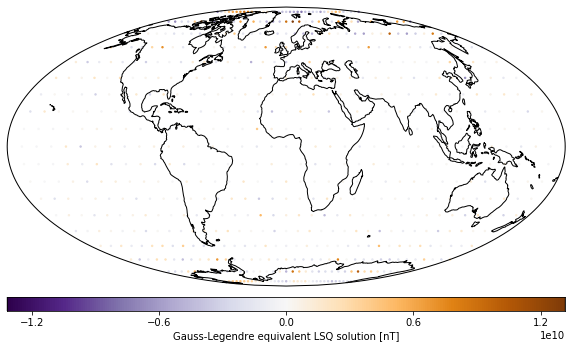

In [111]:
sds_util.plot_cartopy_global_new(core.lat, core.lon, data=M, plot_quality = "high", cmap = 'PuOr_r', title="Gauss-Legendre equivalent LSQ solution", scale_uneven = False)

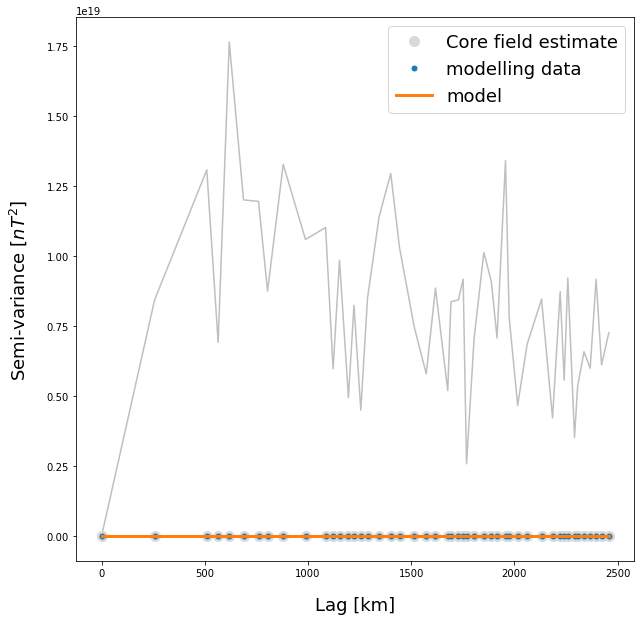

In [112]:
N_sim = 1
#% SEMI-VARIOGRAM
core.sv_zs(core.N_grid,1,np.ravel(M).reshape(-1,1),core.sort_d,core.n_lags,core.max_cloud)

plt.figure(figsize=(10,10))
plt.plot(core.lags,core.pics_zs[:,0],color = '0.75')    
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='Core field estimate')
plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',linewidth = 3,label='model')
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.legend(loc='best',fontsize=18)
plt.show()

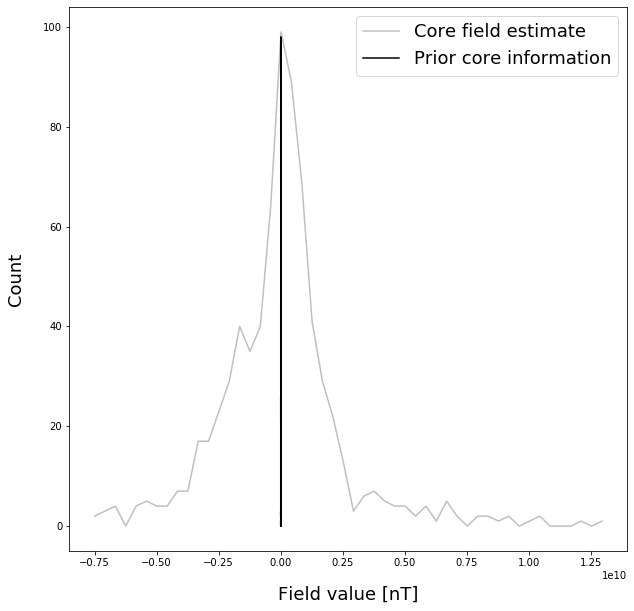

In [113]:
#% HISTOGRAM
plt.figure(figsize=(10,10))    
y,binEdges=np.histogram(np.ravel(M).reshape(-1,1)[:,0],bins=50,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-',color = '0.75',label='Core field estimate')    

y,binEdges=np.histogram(core.data,bins=50,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'k-',label='Prior core information')
plt.legend(loc='best',fontsize=18)
plt.xlabel('Field value %s' % "[nT]",fontsize=18,labelpad=18)
plt.ylabel('Count',fontsize=18,labelpad=18)
plt.show()